# Benchmarking Different Methods

In this task we will benchmark a number of different methods evaluating both performance and quality 
of solutions. 

We start with looking at the real-world application for Mr. Wayne of Wayne Enterprises. 

Here we introduct three new methods some which we will scale later for large random graphs
- DMRG
    By far one of the most accurate methods arround. Generally restricted to lower dimensions as it scales
    poorly due to growth of entanglement. In these classical Ising type of problems, however, we can push it
    to see how it performs compares to other methods
    
- Exact Diagonalization or FCI
    This is qualitatively the best method around bout cannot deal with graphs with more than 12-16 (depending on memory avaiable, in most conventional systems. Of-course can be scaled to larger with distributed projective techniques).
    
- Mean Field Solution
    The worst method around in terms of accuracy, but often a good starting point for other calculations as initial conditions or guesses. In this problem it will frequently have unstable solutions.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import pandas as pd
import time
import matplotlib

import flatnetwork as fnmod

from abstract_udmis import AbstractUDMIS
%matplotlib inline
sns.set(rc={'figure.figsize':(15,12)})

font = {'family' : 'Dejavu Sans',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

u = 1.35

In [11]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)        
        #print(self.num_vertices)
        
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges

    def get_edges(self):
        edges = list()
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges.append([i,j])
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices) 

In [12]:

graph = [
            (1.19, 4.25),
            (2.71, 3.48),
            (1.19, 3.51),
            (2, 3.38),
            (1.12, 2.86),
            (1.70, 2.42),
            (2.36, 2.54),
            (1.52, 1.48),
            (2.15, 1.54),
            (2.14, 1.87),
            (1.72, 0.86),
            (2.29, 0.87)
        ]

In [13]:
udmis = UDMIS(u, graph[::-1])
edges = {(x[0],x[1]) : u for x in udmis.get_edges()}
maxl = max([x[1]-x[0] for x in edges])
L = udmis.num_vertices

print(edges)
print(maxl)

{(0, 2): 1.35, (1, 3): 1.35, (2, 3): 1.35, (2, 4): 1.35, (3, 6): 1.35, (4, 5): 1.35, (5, 6): 1.35, (5, 7): 1.35, (5, 8): 1.35, (5, 9): 1.35, (6, 9): 1.35, (7, 8): 1.35, (7, 9): 1.35, (7, 10): 1.35, (7, 11): 1.35, (8, 9): 1.35, (8, 10): 1.35, (8, 11): 1.35, (10, 11): 1.35}
4


In [14]:
fn = fnmod.FlatNetwork(udmis.num_vertices,edges,{},maxl)

In [15]:
#Run MF

fn.runMF(u = u, seed = 0, maxiter=10)

** Current Energy:  -1.0 Delta(mf)  10.0
** Current Energy:  10.600000000000005 Delta(mf)  11.224972160321824
** Current Energy:  -1.0 Delta(mf)  11.224972160321824
** Current Energy:  10.600000000000005 Delta(mf)  11.224972160321824
** Current Energy:  -1.0 Delta(mf)  11.224972160321824
** Current Energy:  10.600000000000005 Delta(mf)  11.224972160321824
** Current Energy:  -1.0 Delta(mf)  11.224972160321824
** Current Energy:  10.600000000000005 Delta(mf)  11.224972160321824
** Current Energy:  -1.0 Delta(mf)  11.224972160321824
** Current Energy:  10.600000000000005 Delta(mf)  11.224972160321824


(-1.0, array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]))

In [16]:
#Run DMRG

e, mps = fn.run() 

amp = np.array(mps.getAmp())        
ampl = np.where(np.abs(amp)>1.0e-8)[0]
ampv = amp[ampl]
config = [bin(x)[2:].zfill(L) for x in ampl]

print(config)
print(ampv**2)        

Schedule:  0  D =  1
Beginning sweep:  0 of 5
Sweep Energy:  [-5.]
Beginning sweep:  1 of 5
Sweep Energy:  [-5.]
-----------
Schedule:  1  D =  2
Beginning sweep:  0 of 5
Sweep Energy:  [-5.]
Beginning sweep:  1 of 5
Sweep Energy:  [-5.]
-----------
Schedule:  2  D =  2
Beginning sweep:  0 of 5
Sweep Energy:  [-5.]
Beginning sweep:  1 of 5
Sweep Energy:  [-5.]
-----------
Schedule:  3  D =  2
Beginning sweep:  0 of 5
Sweep Energy:  [-5.]
Beginning sweep:  1 of 5
Sweep Energy:  [-5.]
-----------
Schedule:  4  D =  3
Beginning sweep:  0 of 5
Sweep Energy:  [-5.]
Beginning sweep:  1 of 5
Sweep Energy:  [-5.]
-----------
['110010000101', '110010000110', '110010100001', '110010100010', '110010101000', '110010110000']
[1.40361273e-02 3.38137978e-04 7.66787227e-02 8.14833222e-01
 2.15407136e-03 9.19597182e-02]


In [7]:
#Run ED for exact answers
#Degenerate States Exist

ev, psi0 = fn.runED(nstates=2)
print('Exact Energy = ',ev)

ampl = np.where(np.abs(psi0)>1.0e-8)[0]
ampv = psi0[ampl]
config = [bin(x)[2:].zfill(L) for x in ampl]
print(config)
print(ampv**2)

Exact Energy =  [-5. -5.]
['100110000101', '100110000101', '100110000110', '100110000110', '110010000101', '110010000101', '110010000110', '110010000110', '110010100001', '110010100001', '110010100010', '110010100010', '110010101000', '110010101000', '110010110000', '110010110000']
[[3.05541535e-02 2.04108827e-01]
 [3.05541535e-02 2.04108827e-01]
 [1.70107123e-02 8.48079757e-03]
 [1.70107123e-02 8.48079757e-03]
 [3.08948506e-01 3.84241539e-01]
 [3.08948506e-01 3.84241539e-01]
 [1.43124238e-01 1.55759393e-02]
 [1.43124238e-01 1.55759393e-02]
 [4.84980815e-01 3.83442937e-02]
 [4.84980815e-01 3.83442937e-02]
 [1.97366607e-04 1.00659515e-02]
 [1.97366607e-04 1.00659515e-02]
 [1.47522893e-02 3.37661643e-01]
 [1.47522893e-02 3.37661643e-01]
 [4.31919626e-04 1.52100910e-03]
 [4.31919626e-04 1.52100910e-03]]


# Large-scale Benchmarking

For this large-scale benchmarking purposes we will use a series of random flat-graphs of varying lengths 
to study different large-scale methods. 

- Simulated Annealing
- Quantum Annealing
- DMRG
- MF

In [17]:
class UDMIS2(AbstractUDMIS):
    def __init__(self, u, L, edges):
        super().__init__()
        self.u, self.edges = u, edges
        self.num_vertices = L
                
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
       
        #connections list
        self.clist = self.makeConnList()
        #print(self.clist)
        
    def makeConnList(self):
        
        clist = {}
        for i in range(self.num_vertices):
            clist[i] = []
            
        for pair in self.edges:
            clist[pair[0]] += [pair[1]]
            clist[pair[1]] += [pair[0]]
            
        return clist
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        
        for pair in self.edges:
            interaction_term += self.occupations[pair[0]]*self.occupations[pair[1]]
            
        for i in range(self.num_vertices):
            vertex_term += self.occupations[i]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
                
        connections = self.clist[i]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices) 

In [18]:
# First generate random graphs of different sizes that we will use for our comparisons
# We will allow at-most min(1/2*L, 20) length of interaction between vertices 
# 50% of the interactions are allowed to be nearest-neighbor
# 20% of the vertices will have long-range interactions 
# Fixing strenght of AFM coupling to u = 1.35

edgesColl = []
wijColl = []
maxlColl = []

Ls = range(20,110,10)
for L in Ls:   
    edges, wij, maxl = fnmod.random_flat_graph(L, min(L/2,20), 0.5, 0.25, u)
    edgesColl.append(edges)
    wijColl.append(wij)
    maxlColl.append(maxl)
    

In [19]:
edgesColl[0]

{(12, 13): 1.35,
 (15, 16): 1.35,
 (0, 1): 1.35,
 (3, 4): 1.35,
 (7, 8): 1.35,
 (9, 10): 1.35,
 (18, 19): 1.35,
 (4, 5): 1.35,
 (6, 7): 1.35,
 (5, 8): 1.35,
 (0, 5): 1.35,
 (2, 11): 1.35,
 (3, 5): 1.35,
 (8, 14): 1.35}

In [20]:

Energys = np.zeros([4,len(Ls)])
sEnergys = np.zeros([4,len(Ls)])

Steps = np.zeros([4,len(Ls)])
Times = np.zeros([4,len(Ls)])


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


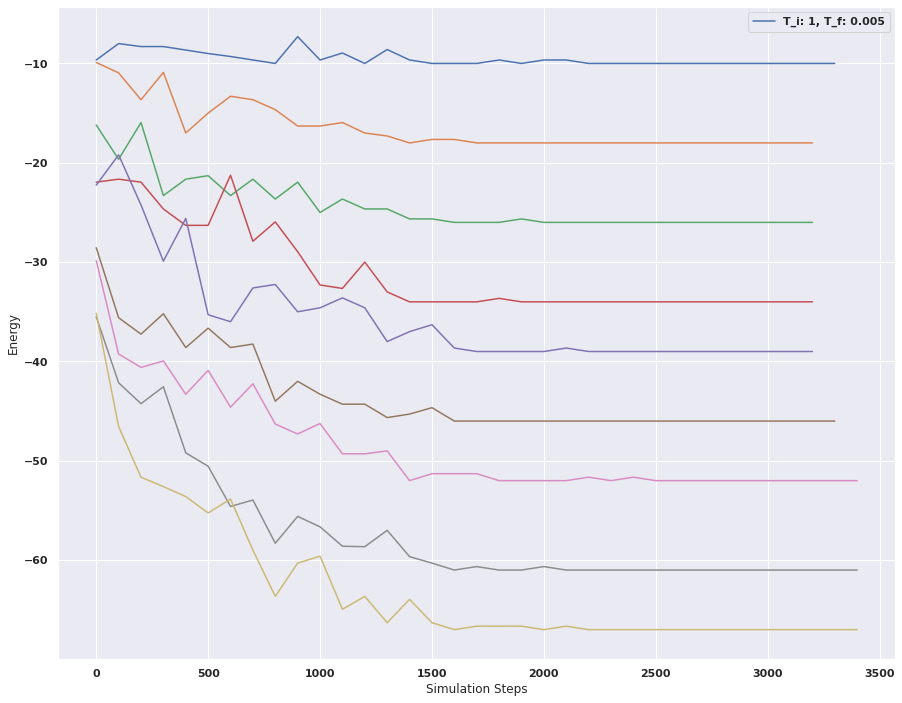

In [21]:
for dpt in range(len(Ls)):
    udmis = UDMIS2(u, Ls[dpt], edgesColl[dpt])

    
    #Start with Simulated Annealing
    N = 5000
    # T_i_list = [100, 10, 1000, 500, 50, 5, 1]
    # T_i_list = [100, 1]
    # T_i_list = [1]
    # T_f_list = [0.01, 0.001, 0.1, 0.5, 1]
    # T_f_list = [0.01, 0.005]

    # params_list = list(itertools.product(T_i_list, T_f_list))

    # params_list = [[100, 0.01]]
    # params_list = [[100, 0.01], [1, 0.01]]
    # params_list = [[100, 0.01], [100, 0.005]]
    # params_list = [[100, 0.01], [1, 0.005]]
    params_list = [[1, 0.005]]

    convergence_points = list()
    legend_labels = list()
    occupation_list = list()
    try:
        
        for T_i, T_f in params_list:

            start_time = time.perf_counter()
            
            t = np.arange(N+1)
            T = T_i * ((T_f/T_i) ** (t/N))
            # print(T)
            simulation_steps = []

            oldE = 1000.0
            cnt = 0
            
            #eqbsteps
            eqbCount = 1500
            extraDelay = 500
            eqbTime = None
            
            #For statistics
            ns = 1000
            dataElist = []
            
            for t in range(N):

                temp = T[t]
                E = udmis.mc_step(T=temp)

                if t % 100 == 0:
                    # print(t, E, udmis.occupations)
                    simulation_steps.append({'Simulation Steps':t, 'Energy': E, 'Occupations': udmis.occupations})

                occupations_rep = ""
                for i in udmis.occupations:
                    occupations_rep = occupations_rep+str(int(i))

                occupation_list.append(occupations_rep)

                #print('Step ',t,'E = ',E,'dE = ',abs(oldE-E))
                if(t>eqbCount and abs(oldE-E)<1.0e-4):
                    cnt += 1
                    eqbTime = eqbTime if(not eqbTime is None) else t
                    
                oldE = E
                
                if(cnt>extraDelay and cnt<=extraDelay+ns):                    
                    dataElist.append(E)
                                        
                elif(cnt>extraDelay+ns):
                    break
                
            simulation_steps_df = pd.DataFrame(simulation_steps)
            fig = sns.lineplot(data=simulation_steps_df, x="Simulation Steps", y="Energy")
            new_legend = 'T_i: {0}, T_f: {1}'.format(T_i, T_f)
            legend_labels.append(new_legend)
            end_time = time.perf_counter()
                       
            Energys[0][dpt] = np.average(dataElist)
            sEnergys[0][dpt] = np.std(dataElist)
            Steps[0][dpt] = eqbTime
            Times[0][dpt] = end_time - start_time
            
        fig.legend(legend_labels)
        
    except Exception as e:
        print(T_i, T_f)
        print(T)
        print(e)

Text(0, 0.5, 'Energy')

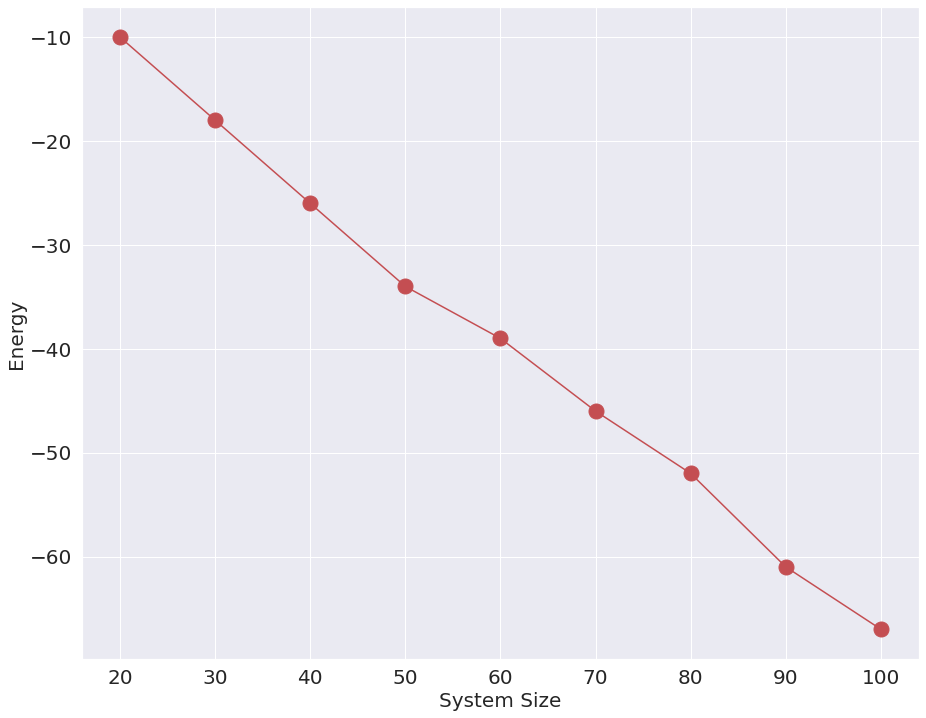

In [36]:
font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 32}
matplotlib.rc('font', **font)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('font', size=20)
plt.rc('legend', fontsize=20)

plt.errorbar(Ls,Energys[0],sEnergys[0],fmt='-or',markersize=15)
plt.xlabel('System Size')
plt.ylabel('Energy')


In [45]:

sweepd = [1,3,3,4,5]
sweepi = [5,5,5,5,5]
sweepn = [1.0e-2,1.0e-3,1.0e-4,1.0e-5,1.0e-6]

for dpt in range(len(Ls)):
    fn = fnmod.FlatNetwork(Ls[dpt],edgesColl[dpt],wijColl[dpt],maxlColl[dpt])
    
    print("\nDMRG for L = ",Ls[dpt])
    start_time = time.perf_counter()
    e, mps = fn.run(sweepd = sweepd, sweepi = sweepi, sweepn = sweepn)
    end_time = time.perf_counter()
    
    Energys[1][dpt] = e    
    Times[1][dpt] = end_time - start_time
    


DMRG for L =  20
Schedule:  0  D =  1
Beginning sweep:  0 of 5
Sweep Energy:  [-10.]
Beginning sweep:  1 of 5
Sweep Energy:  [-10.]
-----------
Schedule:  1  D =  3
Beginning sweep:  0 of 5
Sweep Energy:  [-10.]
Beginning sweep:  1 of 5
Sweep Energy:  [-10.]
-----------
Schedule:  2  D =  3
Beginning sweep:  0 of 5
Sweep Energy:  [-10.]
Beginning sweep:  1 of 5
Sweep Energy:  [-10.]
-----------
Schedule:  3  D =  4
Beginning sweep:  0 of 5
Sweep Energy:  [-10.]
Beginning sweep:  1 of 5
Sweep Energy:  [-10.]
-----------
Schedule:  4  D =  5
Beginning sweep:  0 of 5
Sweep Energy:  [-10.]
Beginning sweep:  1 of 5
Sweep Energy:  [-10.]
-----------

DMRG for L =  30
Schedule:  0  D =  1
Beginning sweep:  0 of 5
Sweep Energy:  [-16.]
Beginning sweep:  1 of 5
Sweep Energy:  [-16.]
-----------
Schedule:  1  D =  3
Beginning sweep:  0 of 5
Sweep Energy:  [-16.]
Beginning sweep:  1 of 5
Sweep Energy:  [-16.]
-----------
Schedule:  2  D =  3
Beginning sweep:  0 of 5
Sweep Energy:  [-17.9038144]


Text(0, 0.5, 'Energy')

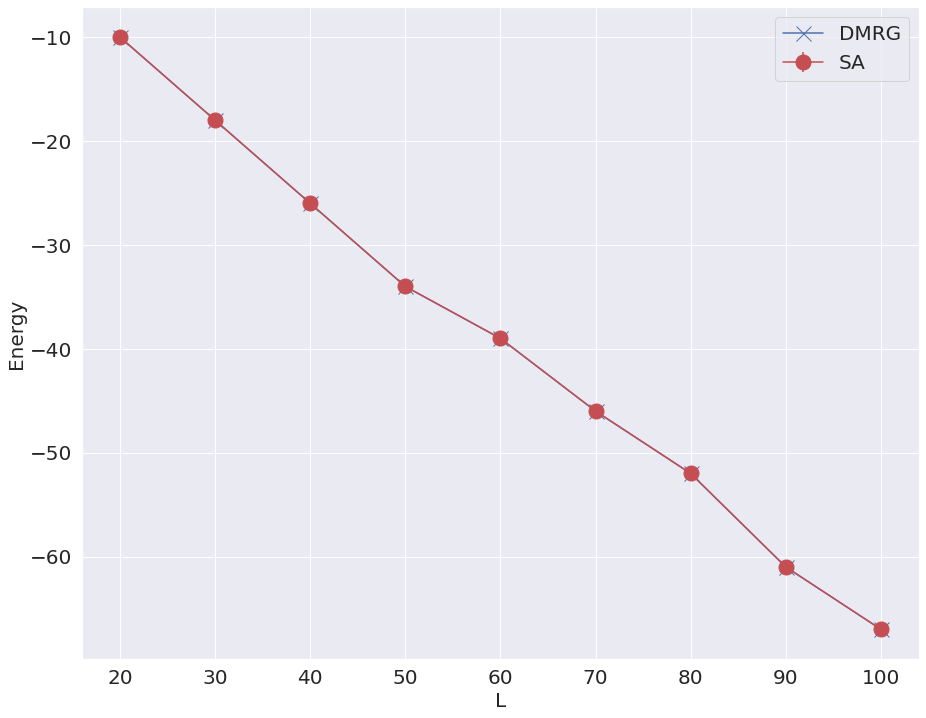

In [46]:
font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 32}
matplotlib.rc('font', **font)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('font', size=20)
plt.rc('legend', fontsize=20)

plt.plot(Ls,Energys[1],'-xb',markersize=15, label='DMRG')
plt.errorbar(Ls,Energys[0],sEnergys[0],fmt='-or',markersize=15, label='SA')
plt.legend()
plt.xlabel('L')
plt.ylabel('Energy')

In [47]:
for dpt in range(len(Ls)):
    fn = fnmod.FlatNetwork(Ls[dpt],edgesColl[dpt],wijColl[dpt],maxlColl[dpt])
    
    print("\nMF for L = ",Ls[dpt])
    start_time = time.perf_counter()
    e, mfstate = fn.runMF()
    end_time = time.perf_counter()
    
    Energys[2][dpt] = e    
    Times[2][dpt] = end_time - start_time


MF for L =  20
** Current Energy:  -5.65 Delta(mf)  4.898979485566356
** Current Energy:  -3.200000000000001 Delta(mf)  6.082762530298219
** Current Energy:  -5.65 Delta(mf)  6.082762530298219
** Current Energy:  -3.200000000000001 Delta(mf)  6.082762530298219
** Current Energy:  -5.65 Delta(mf)  6.082762530298219
** Current Energy:  -3.200000000000001 Delta(mf)  6.082762530298219
** Current Energy:  -5.65 Delta(mf)  6.082762530298219
** Current Energy:  -3.200000000000001 Delta(mf)  6.082762530298219
** Current Energy:  -5.65 Delta(mf)  6.082762530298219
** Current Energy:  -3.200000000000001 Delta(mf)  6.082762530298219
** Current Energy:  -5.65 Delta(mf)  6.082762530298219
** Current Energy:  -3.200000000000001 Delta(mf)  6.082762530298219

MF for L =  30
** Current Energy:  -9.65 Delta(mf)  5.385164807134504
** Current Energy:  -9.500000000000002 Delta(mf)  6.164414002968976
** Current Energy:  -9.65 Delta(mf)  6.164414002968976
** Current Energy:  -9.500000000000002 Delta(mf)  6.

Text(0, 0.5, 'Energy')

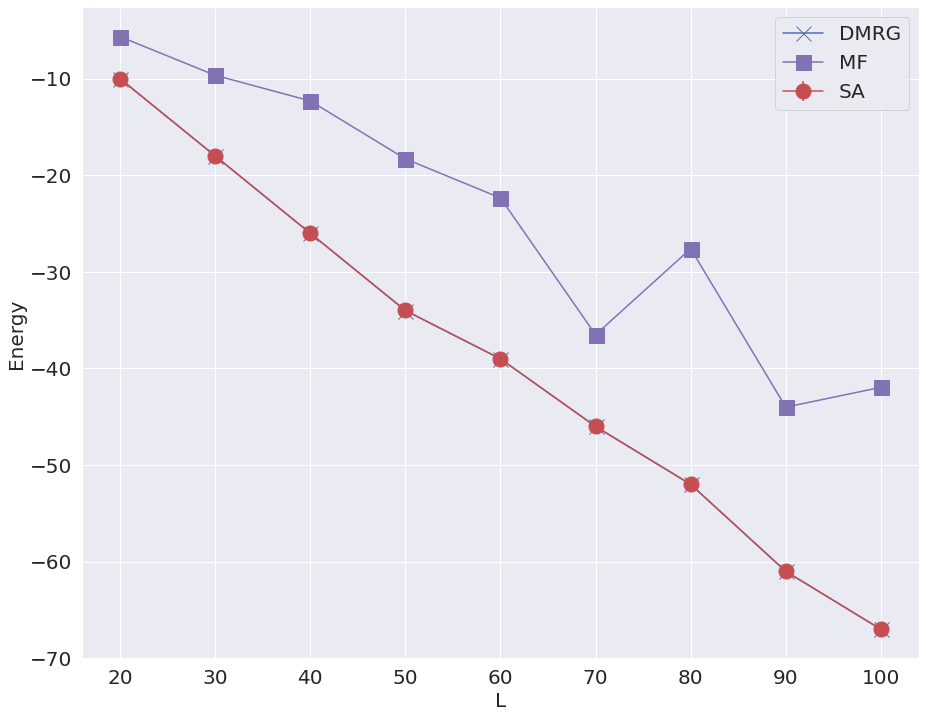

In [48]:
font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 32}
matplotlib.rc('font', **font)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('font', size=20)
plt.rc('legend', fontsize=20)

plt.errorbar(Ls,Energys[0],sEnergys[0],fmt='-or',markersize=15, label='SA')
plt.plot(Ls,Energys[1],'-xb',markersize=15, label='DMRG')
plt.plot(Ls,Energys[2],'-sm',markersize=15, label='MF')
plt.legend()
plt.xlabel('L')
plt.ylabel('Energy')

Text(0, 0.5, 'Time')

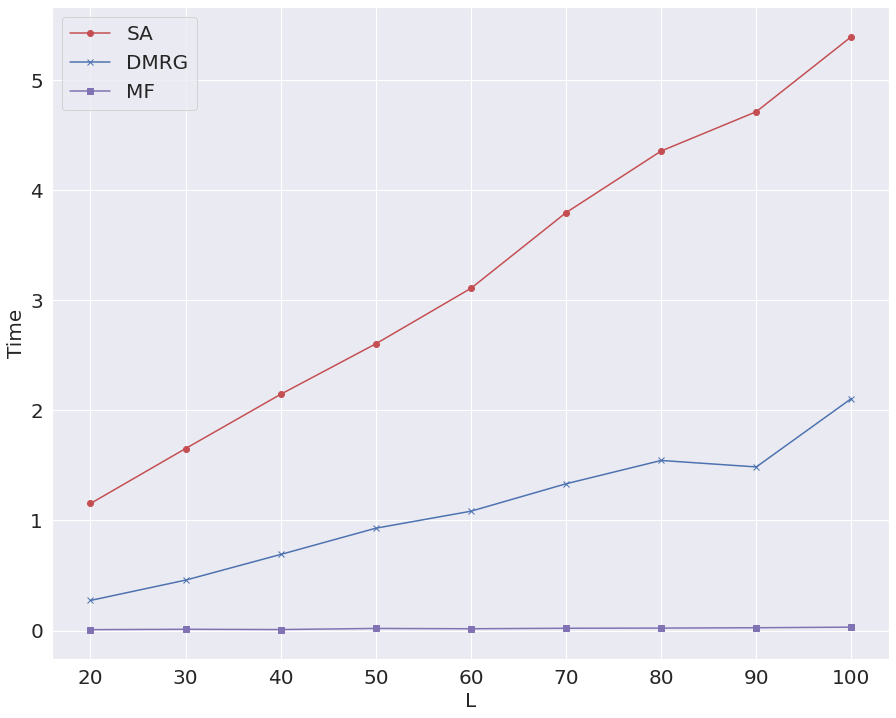

In [49]:
font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 32}
matplotlib.rc('font', **font)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('font', size=20)
plt.rc('legend', fontsize=20)

plt.plot(Ls,Times[0],'-or',label='SA')
plt.plot(Ls,Times[1],'-xb',label='DMRG')
plt.plot(Ls,Times[2],'-sm',label='MF')
plt.legend()
plt.xlabel('L')
plt.ylabel('Time')